## inizio

In [9]:
import h5py
import os
import numpy as np
import numpy as np
from tensorflow.keras.models import load_model

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import Lasso
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
#import pymrmr
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc




# Percorso del file HDF5 da cui caricare i dati
load_path = "/Users/alessiamenozzi/Desktop/ThesisPlaques/classificator_data.h5"
#load_path = "C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\classificator_data.h5"

# Inizializza le liste per contenere i dati
loaded_class_images = []
loaded_class_labels = None
loaded_patients = None

# Apre il file HDF5 in modalità lettura
with h5py.File(load_path, 'r') as hf:
    # Itera su tutti i gruppi nel file HDF5
    for group_name in hf.keys():
        # Controlla se il nome del gruppo inizia con "patient_"
        if group_name.startswith("patient_"):
            group = hf[group_name]
            # Carica le immagini dal dataset 'images' all'interno del gruppo
            loaded_class_images.append(np.array(group['images']))
        elif group_name == "labels":
            # Carica le etichette dal dataset 'labels'
            loaded_class_labels = hf['labels'][:]
        elif group_name == "patients":
            # Carica i numeri dei pazienti dal dataset 'patients'
            loaded_patients = hf['patients'][:]

print(f"Dati caricati da {load_path}")
print(f"Numero di pazienti: {len(loaded_class_images)}")
print(f"Esempio di immagini per paziente: {loaded_class_images[0].shape}")


# Carica il file CSV
file_path = "/Users/alessiamenozzi/Desktop/ThesisPlaques/data_rad_clin_DEF.csv"
#file_path = "C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\data_rad_clin_DEF.csv"
data = pd.read_csv(file_path)

# Lista degli ID da escludere
ids_to_exclude = ["patient_TC_19", "patient_TC_40", "patient_TC_88", "patient_TC_150", "patient_TC_193"]

# Filtra il DataFrame per escludere le righe con gli ID specificati
filtered_data = data[~data['IDs_new'].isin(ids_to_exclude)]

# Estrae i valori dalla colonna 'label' del DataFrame filtrato
labels_column = filtered_data['label']

# Converte i valori della colonna 'label' in numeri interi
labels = labels_column.astype(int).tolist()

labels=np.array(labels)
print("Labels:", labels)
print("Number of labels:", len(labels))


# Carica il modello encoder
encoder = load_model("/Users/alessiamenozzi/Desktop/ThesisPlaques/encoder_models/encoder_model32.h5", compile=False)
#encoder = load_model("C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\encoder_models\\encoder_model64.h5", compile=False)

# Funzione per ottenere le feature da una singola immagine
def get_features_from_image(image):
    image = image.astype('float32')
    image = image / 255.0
    # Ottieni le feature dall'encoder
    if len(image.shape) == 2:  # Se l'immagine è 64x64
        image = np.expand_dims(image, axis=-1)  # Aggiungi canale se necessario (per immagini in bianco e nero)
    image = np.expand_dims(image, axis=0)  # Aggiungi dimensione batch
    features = encoder.predict(image, verbose=False)
    features = np.squeeze(features)
    #print(features.shape)
    return np.array(features)

# Lista per salvare le feature delle immagini
patients = []

# Ottieni le feature per ogni immagine nella lista
for i in range(len(loaded_class_images)):
    features_list = []
    for img in loaded_class_images[i]:
        features = get_features_from_image(img)
        features_list.append(features)
    fetures_list = np.array(features_list)
    patients.append(features_list)

Dati caricati da /Users/alessiamenozzi/Desktop/ThesisPlaques/classificator_data.h5
Numero di pazienti: 124
Esempio di immagini per paziente: (28, 64, 64)
Labels: [0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0
 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0
 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 1 1 0 1 0 1]
Number of labels: 124


## funzioni

In [10]:
## FILE DI FUNZIONI
import h5py
import os
import numpy as np
import numpy as np
from tensorflow.keras.models import load_model

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import Lasso
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
#import pymrmr


from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc


def continue_array(filtered_patients, labels):
    all_features = []
    for patient in filtered_patients:
        for image_features in patient:
            all_features.append(image_features)

    all_features_array = np.array(all_features)

    # Print the shape of the combined features array
    #print(f"Shape of combined features array: {all_features_array.shape}")

    # Initialize the new expanded labels and patient IDs vectors
    expanded_labels = []
    expanded_patient_ids = []

    # Assuming labels and loaded_patients are already defined
    # labels: A list of length 124 with labels for each patient
    # loaded_patients: A list of length 124 with IDs for each patient

    # Iterate over the filtered patients and expand the labels and patient IDs
    for i in range(len(filtered_patients)):
        num_images = len(filtered_patients[i])  # Number of images for the current patient
        expanded_labels.extend([labels[i]] * num_images)  # Assign the same label to all images of the patient
        expanded_patient_ids.extend([loaded_patients[i]] * num_images)  # Assign the same patient ID to all images of the patient

    # Convert the lists to NumPy arrays
    expanded_labels_array = np.array(expanded_labels)
    expanded_patient_ids_array = np.array(expanded_patient_ids)

    # Print the shapes of the new arrays to verify
    #print(f"Shape of expanded labels array: {expanded_labels_array.shape}")
    #print(f"Shape of expanded patient IDs array: {expanded_patient_ids_array.shape}")
    return all_features_array, expanded_labels_array, expanded_patient_ids_array


def filter_highly_correlated_features(df, corr, threshold=0.85):
    columns = np.full((corr.shape[0],), True, dtype=bool)
    removed_features = []

    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= threshold:
                if columns[j]:
                    columns[j] = False
                    removed_features.append(df.columns[j])

    #selected_columns = df.columns[columns]
    return removed_features



def remove_features_from_patients(patients, features_to_remove):
    # Estrai gli indici delle caratteristiche da rimuovere
    feature_indices_to_remove = [int(feature.split('_')[1]) for feature in features_to_remove]
    
    # Rimuovi le caratteristiche corrispondenti dagli array dei pazienti
    final_patients = []
    for patient in patients:
        new_patients = []
        for image_features in patient:
            new_patient = np.delete(image_features, feature_indices_to_remove, axis=0)
            new_patients.append(new_patient)
        final_patients.append(np.array(new_patients))    

    return final_patients


def perform_correlation(z_train, y_train, numero = 32, threshold = 0.85):
    # Supponiamo che loaded_patients contenga le etichette dei pazienti

    all_images, _, _= continue_array(z_train, y_train)

    # Creazione del DataFrame con le immagini come righe e le features come colonne
    df = pd.DataFrame(all_images, columns=[f'feature_{i}' for i in range(numero)])

    # Visualizzazione del DataFrame
    corr_matrix = df.corr()

    # Se vuoi anche visualizzare la matrice di correlazione con Seaborn
    #plt.figure(figsize=(12, 10))
    #sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    #plt.title("Feature Correlation Matrix")
    #plt.show()  
    
    features_selected = filter_highly_correlated_features(df, corr_matrix, threshold)
    
    return features_selected



## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    # Fit Lasso regression model
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)

    # Get coefficients
    coefficients = lasso.coef_

    # Select features with non-zero coefficients
    selected_features = np.where(coefficients != 0)[0]

    # Create new feature matrix with only selected features
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    # Create new feature matrix with only selected features
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FEATURE SELECTION MRMR
def mrmr_feature_selection(X, y, num_features):
    feature_names = [f'feature_{i}' for i in range(X.shape[1])]
    data = pd.DataFrame(X, columns=feature_names)
    data['target'] = y
    data.columns = data.columns.astype(str)
    selected_features = pymrmr.mRMR(data, 'MIQ', num_features)
    selected_indices = [data.columns.get_loc(feature) for feature in selected_features]
    # Crea una nuova matrice delle caratteristiche con solo le caratteristiche selezionate
    X_selected = X[:, selected_indices]

    return X_selected, selected_indices

## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    # Inizializza il classificatore Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    # Addestra il modello
    rf.fit(X, y)
    # Ottieni l'importanza delle caratteristiche
    feature_importances = rf.feature_importances_
    # Seleziona gli indici delle caratteristiche più importanti
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    # Crea una nuova matrice di caratteristiche con solo le caratteristiche selezionate
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FUNZIONE PER RIMUOVERE FEATURES SELEZIONATE
def filter_patients_features(filtered_patients, selected_features):
    """
    Removes the non-selected features from the filtered_patients array.

    Parameters:
    filtered_patients (list of numpy.ndarray): The list containing patients' images' features.
    selected_features (numpy.ndarray): The indices of the selected features.

    Returns:
    list of numpy.ndarray: The new filtered_patients array with only the selected features.
    """
    filtered_patients_selected = []

    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected




In [11]:
def find_best_threshold_features(results_rf, selector):
    best_thresholds = []
    best_num_features=[]
    best_alpha=[]

    for i in range(len(results_rf)):
        fold_results = results_rf[i][selector]
        
        # Inizialmente, tutti gli indici con il massimo F1 score
        best_f1_indices = np.where(fold_results['f1'] == np.max(fold_results['f1']))[0]
        print("best_f1_indices prima volta ", best_f1_indices)
        
        if len(best_f1_indices) > 1:
            print("sto tagliando")
            # In caso di parità di F1, considera il pr_auc
            max_pr_auc = max(fold_results['pr_auc'][j] for j in best_f1_indices)
            best_f1_indices = [j for j in best_f1_indices if fold_results['pr_auc'][j] == max_pr_auc]
            print("best_f1_indices 2 volta ", best_f1_indices)
            # In caso di ulteriore parità, considera l'accuracy
            if len(best_f1_indices)!=1:
                max_accuracy = max(fold_results['accuracy'][j] for j in best_f1_indices)
                best_f1_indices = [j for j in best_f1_indices if fold_results['accuracy'][j] == max_accuracy]
                print("best_f1_indices 3 volta ", best_f1_indices)
                if len(best_f1_indices)!=1:
                    max_roc_auc = max(fold_results['roc_auc'][j] for j in best_f1_indices)
                    best_f1_indices = [j for j in best_f1_indices if fold_results['roc_auc'][j] == max_roc_auc]
                    print("best_f1_indices 4 volta ", best_f1_indices)
                    #best_f1_indices= best_f1_indices[0]
           
        best_index = best_f1_indices[0]
        print("best index: ", best_index)


        # Ottieni l'indice finale del miglior F1 score
        best_thresholds.append(fold_results['best_threshold'][best_index])

        if selector == 'lasso':
            best_alpha.append(fold_results['alpha'][best_index])
        else:
            best_num_features.append(fold_results['num_features'][best_index])

    
    # Calcola la media delle soglie migliori
    mean_best_threshold = np.mean(best_thresholds)

    if selector == 'lasso':
        mean_best_alpha= np.mean(best_alpha)
        mean_param=mean_best_alpha
    else:
        mean_best_features = np.mean(best_num_features)
        mean_param=mean_best_features


    return mean_best_threshold, mean_param


In [12]:

# Supponiamo che tu abbia un elenco di colori predefiniti per i fold
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Supponiamo che results_rf sia un dizionario di dizionari dove:
# results_rf[i][selector] contiene i dati per il fold i e il selettore selector.
# results_test_rf contiene i dati per il set di test finale per ogni selector.

def plot_results(results_rf, results_test_rf, selector):

    # Plotta i risultati per PR AUC
    if selector == 'lasso':
        
        plt.figure()
        for i in range(len(results_rf)):
            fold_results = results_rf[i][selector]
            plt.plot(fold_results['alpha'], fold_results['pr_auc'], marker='o', linestyle='-', color=colors[i % len(colors)], label=f'Fold {i+1}')
        
        # Plot dei risultati del set di test
        plt.plot(results_test_rf[selector]['alpha'], results_test_rf[selector]['pr_auc'], marker='x', linestyle='--', color='black', label='Test Set')
        
        plt.xlabel('Alpha Values')
        plt.ylabel('AUC')
        plt.title(f'Alpha Values vs PR AUC for {selector} selector')
        plt.xscale('log')
        plt.legend()
        plt.show()

        # Plotta i risultati per ROC AUC
        plt.figure()
        for i in range(len(results_rf)):
            fold_results = results_rf[i][selector]
            plt.plot(fold_results['alpha'], fold_results['roc_auc'], marker='o', linestyle='-', color=colors[i % len(colors)], label=f'Fold {i+1}')
        
        # Plot dei risultati del set di test
        plt.plot(results_test_rf[selector]['alpha'], results_test_rf[selector]['roc_auc'], marker='x', linestyle='--', color='black', label='Test Set')
        
        plt.xlabel('Alpha Values')
        plt.ylabel('AUC')
        plt.title(f'Alpha Values vs ROC AUC for {selector} selector')
        plt.xscale('log')
        plt.legend()
        plt.show()


    else:
        plt.figure()
        for i in range(len(results_rf)):
            fold_results = results_rf[i][selector]
            plt.plot(fold_results['num_features'], fold_results['pr_auc'], marker='o', linestyle='-', color=colors[i % len(colors)], label=f'Fold {i+1}')
        
        # Plot dei risultati del set di test
        plt.plot(results_test_rf[selector]['num_features'], results_test_rf[selector]['pr_auc'], marker='x', linestyle='--', color='black', label='Test Set')
        
        plt.xlabel('Number of Features')
        plt.ylabel('AUC')
        plt.title(f'Number of Features vs PR AUC for {selector} selector')
        plt.xscale('linear')
        plt.legend()
        plt.show()

        # Plotta i risultati per ROC AUC
        plt.figure()
        for i in range(len(results_rf)):
            fold_results = results_rf[i][selector]
            plt.plot(fold_results['num_features'], fold_results['roc_auc'], marker='o', linestyle='-', color=colors[i % len(colors)], label=f'Fold {i+1}')
        
        # Plot dei risultati del set di test
        plt.plot(results_test_rf[selector]['num_features'], results_test_rf[selector]['roc_auc'], marker='x', linestyle='--', color='black', label='Test Set')
        
        plt.xlabel('Number of Features')
        plt.ylabel('AUC')
        plt.title(f'Number of Features vs ROC AUC for {selector} selector')
        plt.xscale('linear')
        plt.legend()
        plt.show()




## funzione classificazione

In [13]:
def custom_accuracy_score(y_test, y_pred):
    """
    Calcola l'accuratezza per un singolo campione di test.
    
    Args:
    y_test (array-like): Il vero valore di test.
    y_pred (array-like): Il valore predetto.
    
    Returns:
    float: L'accuratezza (1.0 se corrisponde, 0.0 se non corrisponde).
    """
    # Controlla che entrambi abbiano un solo elemento
    if len(y_test) == 1 and len(y_pred) == 1:
        return 1.0 if y_test[0] == y_pred[0] else 0.0
    else:
        raise ValueError("Entrambi y_test e y_pred devono avere un solo elemento.")



In [14]:
def prob_to_binary(predictions_proba, threshold):
        final_predictionarray=[]          
        ## majority voting
        for p in predictions_proba:
            test_patient_predictions=[]
            for proba in p:               
                predictions_binary = 1 if proba[0][1] > threshold else 0
                test_patient_predictions.append(predictions_binary)
            count_0 = np.sum(np.array(test_patient_predictions)==0) 
            count_1 = np.sum(np.array(test_patient_predictions)==1)                                   
            final_prediction = 0 if count_0 > count_1 else 1
            final_predictionarray.append(final_prediction)
         
    
        return final_predictionarray


def classification_method1(selector, alpha, classifier, x_train_expanded, y_train_expanded, patients_test, y_test, features_test, num_features, thresholds=np.arange(0.001, 0.501, 0.001)):

    if num_features != len(x_train_expanded[0]) or alpha != 0:
        if selector == "lasso":
            X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
        elif selector == "logistic": 
            X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
        elif selector == "mrmr":
            X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
        elif selector == "rf":
            X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
        else:
            print("Wrong selector. Choose between: mrmr, rf, logistic, lasso")
            return
        
        features_test = filter_patients_features(features_test, selected_features)

    else:
        X_selected = x_train_expanded

    #print("X_selected[0] ", X_selected[0])
    #print("X_selected[1] ", X_selected[1])
    
    smote = SMOTE(random_state=42)

    # Applicare SMOTE al set di dati di addestramento espanso
    X_resampled, y_resampled = smote.fit_resample(X_selected, y_train_expanded)
    #print(X_selected, " vs Resampled ", X_resampled)
    #print(y_test, "vs resempled " , y_resampled)
    #classifier.fit(X_selected, y_train_expanded)
    classifier.fit(X_resampled, y_resampled)

   
    ### questo trova le probabilità e fa la media
    temp_array = []
    patient_scores = []



    for x in range(len(patients_test)):
        patient_predictions = []
        patient_predictions1 = []
        for i in range(len(features_test[x])):
            dato = features_test[x][i].reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            prediction1 = classifier.predict_proba(dato)[:,1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean=np.mean(patient_predictions1)

        patient_scores.append(mean) ## contiene la media delle probabilità
        temp_array.append(patient_predictions) ## contiene tutte le probabilità


    best_f1_score = 0
    best_threshold = None

    best_prediction=[]
    

    # Valuta le performance utilizzando diverse threshold
    #thresholds = np.arange(0.001, 0.501, 0.001)
    thresholds=[0.5]
    if isinstance(thresholds, (int, float, complex)):
        thresholds=[thresholds]

    ## se non viene specificato usi il parametro di default 
    if(len(thresholds)!=1):
        for threshold in thresholds:
            binary_predictions = prob_to_binary(temp_array, threshold)
            f1 = f1_score(y_test, binary_predictions, zero_division=0)
            best_prediction=binary_predictions
            if f1 > best_f1_score:
                best_f1_score = f1
                best_threshold = threshold
                best_precision = precision_score(y_test, binary_predictions, zero_division=0)
                best_recall = recall_score(y_test, binary_predictions, zero_division=0)
                best_prediction=binary_predictions

    else: ## qui vuol dire che è il set di test che usa la threshold migliore
        best_threshold = thresholds[0]
        best_prediction=prob_to_binary(temp_array, best_threshold)
   
    y_test= np.array(y_test)
    best_prediction=np.array(best_prediction)
    test_accuracy = accuracy_score(y_test, best_prediction)

    return test_accuracy



## Leave one out

In [26]:
from sklearn.model_selection import LeaveOneOut

patients_train1, patients_test, y_train1, y_test, features_train1, features_test= train_test_split(loaded_patients, labels, patients, test_size=0.2, shuffle=False, random_state=1)
#patients_train, patients_val, y_train, y_val, features_train, features_val= train_test_split(loaded_patients, labels, patients, test_size=0.2, shuffle=False, random_state=1)

#selectors=['mrmr', 'rf', 'logistic', 'lasso']
selectors=['rf', 'lasso', 'logistic']

loo = LeaveOneOut()

len_train=patients_train1
i=0





54


In [ ]:
#results_rf = [{} for _ in range(len(selectors)-1)]
results_rf={}
results_test_rf={}

results_rf_alpha = {
                    'alpha': [],
                    'mean_accuracy':[]
            }


for selector in selectors:

    if selector=='lasso':
         for alpha in alpha_values:
              
            i = 0
        
            accuracies=[]
            for train_index, val_index in loo.split(features_train1, y_train1):
                features_train = []
                features_val = []
                
                
                for idx in train_index:
                    features=[]
                    for x in range(len(features_train1[idx])):
                        features.append(features_train1[idx][x])
                    features=np.array(features)
                    features_train.append(features)
                    
                j=0
                for idx in val_index:
                    features=[]
                    for x in range(len(features_train1[idx])):
                        features.append(features_train1[idx][x])
                    features=np.array(features)
                    features_val.append(features)

                y_train, y_val = y_train1[train_index], y_train1[val_index]
                patients_train, patients_val = patients_train1[train_index], patients_train1[val_index]

                ## fine creazione fold


                features=perform_correlation(features_train, y_train, 32, 0.85)

                final_patients_train=remove_features_from_patients(features_train, features)
                final_patients_test=remove_features_from_patients(features_test, features)
                final_patients_val=remove_features_from_patients(features_val, features)

                x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)

        
                rf = RandomForestClassifier(n_estimators=100, random_state=42)
                accuracy= classification_method1(
                        selector, alpha, rf, x_train_expanded, y_train_expanded, 
                        patients_val, y_val, final_patients_val, 0
                )

                accuracies.append(accuracy)
            
            results_rf_alpha['alpha'].append(alpha)
            results_rf_alpha['mean_accuracy'].append(np.mean(accuracies))
            
    else:
        results_rf[selector] = {
                    'num_features': [],
                    'mean_accuracy':[]
            }
        for t in range(2, len(x_train_expanded[0])+1):

            accuracies=[]
            for train_index, val_index in loo.split(features_train1, y_train1):
                features_train = []
                features_val = []
                
                
                for idx in train_index:
                    features=[]
                    for x in range(len(features_train1[idx])):
                        features.append(features_train1[idx][x])
                    features=np.array(features)
                    features_train.append(features)
                    
                j=0
                for idx in val_index:
                    features=[]
                    for x in range(len(features_train1[idx])):
                        features.append(features_train1[idx][x])
                    features=np.array(features)
                    features_val.append(features)

                y_train, y_val = y_train1[train_index], y_train1[val_index]
                patients_train, patients_val = patients_train1[train_index], patients_train1[val_index]

                ## fine creazione fold

                features=perform_correlation(features_train, y_train, 32, 0.85)

                final_patients_train=remove_features_from_patients(features_train, features)
                final_patients_test=remove_features_from_patients(features_test, features)
                final_patients_val=remove_features_from_patients(features_val, features)

                x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)

                rf = RandomForestClassifier(n_estimators=100, random_state=42)
                accuracy= classification_method1(
                        selector, 0, rf, x_train_expanded, y_train_expanded, 
                        patients_val, y_val, final_patients_val, t
                )

                accuracies.append(accuracy)
            
            results_rf[selector]['num_features'].append(t)
            results_rf[selector]['mean_accuracy'].append(np.mean(accuracies))

        i=i+1


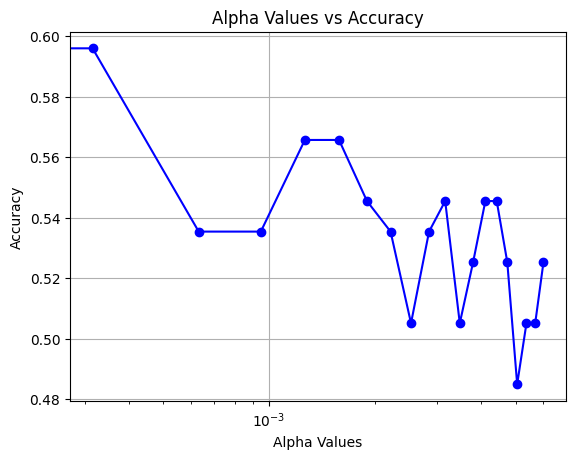

The alpha with the best accuracy is 0.0 with an accuracy of 0.5959595959595959


In [63]:

import matplotlib.pyplot as plt

# Estrai i valori di alpha e accuracy dal dizionario
alpha_values = results_rf_alpha['alpha']
accuracy_values = results_rf_alpha['mean_accuracy']

# Crea il grafico
plt.figure()
plt.plot(alpha_values, accuracy_values, marker='o', linestyle='-', color='b')
plt.xlabel('Alpha Values')
plt.ylabel('Accuracy')
plt.title('Alpha Values vs Accuracy')
plt.xscale('log')  # Scala logaritmica per l'asse x se alpha varia su diversi ordini di grandezza
plt.grid(True)
plt.show()

best_index = accuracy_values.index(max(accuracy_values))
best_alpha = alpha_values[best_index]
best_accuracy = accuracy_values[best_index]

print(f"The alpha with the best accuracy is {best_alpha} with an accuracy of {best_accuracy}")


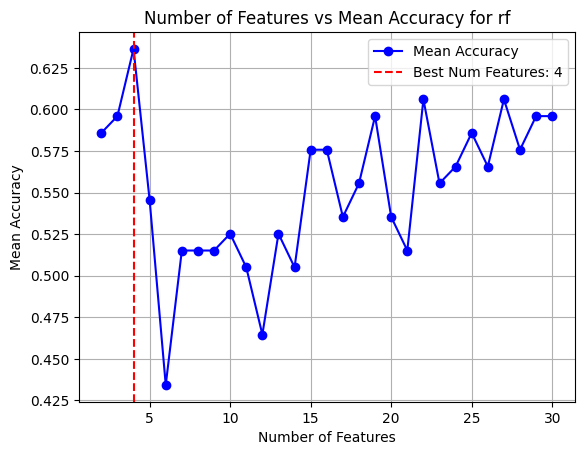

The best number of features for rf is 4 with a mean accuracy of 0.6363636363636364


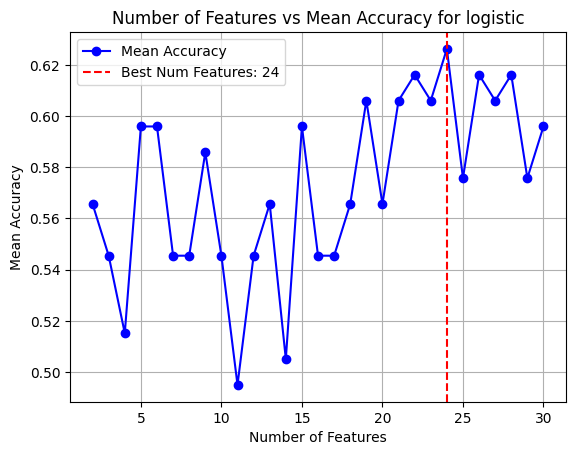

The best number of features for logistic is 24 with a mean accuracy of 0.6262626262626263


In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Funzione per plottare i risultati per ogni selector
def plot_results(results_rf):
    for selector in results_rf.keys():
        num_features = results_rf[selector]['num_features']
        mean_accuracy = results_rf[selector]['mean_accuracy']
        
        # Trova il numero di caratteristiche con la miglior accuracy
        best_index = mean_accuracy.index(max(mean_accuracy))
        best_num_features = num_features[best_index]
        best_accuracy = mean_accuracy[best_index]
        
        # Crea il grafico
        plt.figure()
        plt.plot(num_features, mean_accuracy, marker='o', linestyle='-', color='b', label='Mean Accuracy')
        plt.axvline(x=best_num_features, color='r', linestyle='--', label=f'Best Num Features: {best_num_features}')
        plt.xlabel('Number of Features')
        plt.ylabel('Mean Accuracy')
        plt.title(f'Number of Features vs Mean Accuracy for {selector}')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Stampa il numero di caratteristiche con la miglior accuracy
        print(f"The best number of features for {selector} is {best_num_features} with a mean accuracy of {best_accuracy}")

# Chiama la funzione per plottare i risultati
plot_results(results_rf)


## TEST SET

In [16]:
def prob_to_binary(predictions_proba, threshold):
        final_predictionarray=[]          
        ## majority voting
        for p in predictions_proba:
            test_patient_predictions=[]
            for proba in p:               
                predictions_binary = 1 if proba[0][1] > threshold else 0
                test_patient_predictions.append(predictions_binary)
            count_0 = np.sum(np.array(test_patient_predictions)==0) 
            count_1 = np.sum(np.array(test_patient_predictions)==1)                                   
            final_prediction = 0 if count_0 > count_1 else 1
            final_predictionarray.append(final_prediction)
         
    
        return final_predictionarray


def classification_method(selector, alpha, classifier, x_train_expanded, y_train_expanded, patients_test, y_test, features_test, num_features, thresholds=np.arange(0.001, 0.501, 0.001)):

    if num_features != len(x_train_expanded[0]) or alpha != 0:
        if selector == "lasso":
            X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
        elif selector == "logistic": 
            X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
        elif selector == "mrmr":
            X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
        elif selector == "rf":
            X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
        else:
            print("Wrong selector. Choose between: mrmr, rf, logistic, lasso")
            return
        
        features_test = filter_patients_features(features_test, selected_features)

    else:
        X_selected = x_train_expanded

    #print("X_selected[0] ", X_selected[0])
    #print("X_selected[1] ", X_selected[1])
    
    smote = SMOTE(random_state=42)

    # Applicare SMOTE al set di dati di addestramento espanso
    X_resampled, y_resampled = smote.fit_resample(X_selected, y_train_expanded)
    #print(X_selected, " vs Resampled ", X_resampled)
    #print(y_test, "vs resempled " , y_resampled)
    #classifier.fit(X_selected, y_train_expanded)
    classifier.fit(X_resampled, y_resampled)

   
    ### questo trova le probabilità e fa la media
    temp_array = []
    patient_scores = []

    for x in range(len(patients_test)):
        patient_predictions = []
        patient_predictions1 = []
        for i in range(len(features_test[x])):
            dato = features_test[x][i].reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            prediction1 = classifier.predict_proba(dato)[:,1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean=np.mean(patient_predictions1)

        patient_scores.append(mean) ## contiene la media delle probabilità
        temp_array.append(patient_predictions) ## contiene tutte le probabilità
    


    best_f1_score = 0
    best_threshold = None
    best_precision=0
    best_recall=0
    best_prediction=[]
    

    # Valuta le performance utilizzando diverse threshold
    #thresholds = np.arange(0.001, 0.501, 0.001)
    thresholds=[0.5]
    if isinstance(thresholds, (int, float, complex)):
        thresholds=[thresholds]

    ## se non viene specificato usi il parametro di default 
    if(len(thresholds)!=1):
        for threshold in thresholds:
            binary_predictions = prob_to_binary(temp_array, threshold)
            f1 = f1_score(y_test, binary_predictions)
            if f1 > best_f1_score:
                best_f1_score = f1
                best_threshold = threshold
                best_precision = precision_score(y_test, binary_predictions)
                best_recall = recall_score(y_test, binary_predictions)
                best_prediction=binary_predictions

    else: ## qui vuol dire che è il set di test che usa la threshold migliore
        best_threshold = thresholds
        best_prediction=prob_to_binary(temp_array, best_threshold)
        best_f1_score = f1_score(y_test, best_prediction)
        best_precision = precision_score(y_test, best_prediction)
        best_recall = recall_score(y_test, best_prediction)

    #print(f"La migliore threshold è {best_threshold} con f1score di {best_f1_score} e precision {best_precision} e recall {best_recall}.")

    y_test= np.array(y_test)
    best_prediction=np.array(best_prediction)
    test_accuracy = accuracy_score(y_test, best_prediction)


    #test_precision = precision_score(y_test, best_prediction)
    #test_recall = recall_score(y_test, best_prediction)
    
    precision, recall, _ = precision_recall_curve(y_test, patient_scores)
    pr_auc = average_precision_score(y_test, patient_scores)

    #fpr, tpr, _ = roc_curve(y_test, best_prediction)
    roc_auc= roc_auc_score(y_test, patient_scores)


    conf= confusion_matrix(y_test, best_prediction)

    return best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, best_threshold



In [20]:
features=perform_correlation(features_train1, y_train1, 32, 0.85)

final_patients_train=remove_features_from_patients(features_train1, features)
final_patients_test=remove_features_from_patients(features_test, features)

x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train1)

    
alpha=0
for selector in selectors:
        if(selector=='lasso'): 
            alpha=0.0
        if(selector=='rf'): 
            num_features=4
        if(selector=='logistic'): 
            num_features=24
            
            #num_features = results_rf[selector]['num_features']
            #mean_accuracy = results_rf[selector]['mean_accuracy']
            
            # Trova il numero di caratteristiche con la miglior accuracy
            #best_index = mean_accuracy.index(max(mean_accuracy))
            #best_num_features = num_features[best_index]
 
        rf = RandomForestClassifier(n_estimators=100, random_state=42)

        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method(
                                    selector, alpha, rf, x_train_expanded, y_train_expanded, 
                                    patients_test, y_test, final_patients_test, num_features
                                )

        print(f"For {selector} selector f1 is {best_f1_score}, accuracy is {test_accuracy}, pr_auc is {pr_auc} and roc_auc is {roc_auc}")

For rf selector f1 is 0.15384615384615385, accuracy is 0.56, pr_auc is 0.284839845826688 and roc_auc is 0.35294117647058826


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.499e+02, tolerance: 7.837e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

For lasso selector f1 is 0.14285714285714285, accuracy is 0.52, pr_auc is 0.3173266700404858 and roc_auc is 0.45588235294117646
For logistic selector f1 is 0.13333333333333333, accuracy is 0.48, pr_auc is 0.28359010270774976 and roc_auc is 0.375
